In [1]:
#load and install required packages

In [2]:
#install required packages
%pip install git+https://github.com/MeMartijn/updated-sklearn-crfsuite.git#egg=sklearn_crfsuite
%pip install scikit_learn
%pip install nltk
%pip install seaborn

  Running command git clone --filter=blob:none --quiet https://github.com/MeMartijn/updated-sklearn-crfsuite.git 'C:\Users\ewout\AppData\Local\Temp\pip-install-81bz5f4b\sklearn-crfsuite_9df1a65b0c5c466b878486c1dd930b13'

[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\ewout\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



  Cloning https://github.com/MeMartijn/updated-sklearn-crfsuite.git to c:\users\ewout\appdata\local\temp\pip-install-81bz5f4b\sklearn-crfsuite_9df1a65b0c5c466b878486c1dd930b13
  Resolved https://github.com/MeMartijn/updated-sklearn-crfsuite.git to commit 675038761b4405f04691a83339d04903790e2b95
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\ewout\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\ewout\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0
[notice] To update, run: C:\Users\ewout\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
# import required libraries
import pandas as pd 
import nltk
import sklearn
import scipy.stats
import numpy as np
import seaborn as sns
import sklearn_crfsuite

#from matplotlib 
from matplotlib import pyplot as plt

#from itertools
from itertools import chain

#from sklearn
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [4]:
#load the data and ontologies

In [5]:
#this function turns the file into a list. 
def file2list(fileLocation):
    outputList = []
    with open(fileLocation, 'r', encoding='utf8') as myfile:
        sentences = myfile.read().split('\n\n')
        for sentence in sentences:
                sentenceList = []
                words = sentence.split('\n')
                for word in words:
                    wordsList = []
                    attributes = word.split(' ')
                    for attribute in attributes:
                        wordsList.append(attribute)
                    sentenceList.append(wordsList)
                outputList.append(sentenceList)
    
    return outputList

In [6]:

# train =  file2list('D:\\phd-data\\NER-annotation-data\\Dutch\\5-folds-with-pos-with-cut-sentences\\fold1.txt') 
# test =  file2list('D:\\phd-data\\NER-annotation-data\\Dutch\\5-folds-with-pos-with-cut-sentences\\fold2.txt')

#load the datasets, with training documents as train, and test documents and test
train =  file2list('data/train.bio') 
test =  file2list('data/test.bio')

#remove empty line at the end of the file as this breaks the code
test.pop() 
train.pop()

[['12.1', 'NOUN', 'O'], [')', 'PUNCT', 'O'], ['.', 'PUNCT', 'O']]

In [7]:
%%time 
# calculates the time to open the file
        
#train the NER on the list. there is one set of test and one of training. often 20:80 split
train_sent = train
test_sent = test   # tests the sent (input) of the given list as defined above
train_sent[0] # displayes the first 10 rows in the bio. - each row hs the token (effectively word), followed by pos?, and the bio label


CPU times: total: 0 ns
Wall time: 0 ns


[['Linearbandkeramik', 'NOUN', 'B-ART'],
 ['aus', 'ADP', 'O'],
 ['Meindling', 'PROPN', 'B-LOC'],
 [',', 'PUNCT', 'O'],
 ['Gem', 'PROPN', 'O'],
 ['.', 'PUNCT', 'O']]

In [8]:
#time to load the ontologies 
"""
#Material ontology
materials = pd.read_csv(r'ontologies\Materials.csv') #open the file
materials[materials.columns[2]]= materials[materials.columns[2]].str.lower() #takes the second column (the one with the entities) and makes it all lower case
materials_list = materials[materials.columns[2]].values.tolist() #turns the items into a list
print(materials_list) # outputs the list of terms to see what sort of data it contains
print("\n""\n")

#Taxon ontology
# taxon = pd.read_csv(r'ontologies\Taxon.tsv', sep="\t", error_bad_lines=False) #open the file
# taxon[taxon.columns[8]]= taxon[taxon.columns[8]].str.lower() #takes the second column (the one with the entities) and makes it all lower case
# taxon_list = taxon[taxon.columns[8]].values.tolist() #turns the items into a list
# print(taxon_list[0:100]) # outputs the list of terms to see what sort of data it contains
# print("\n""\n")

#Animal ontology
animal = pd.read_csv(r'ontologies\VernacularName.tsv', sep="\t") #open the file
animal[animal.columns[2]]= animal[animal.columns[2]].str.lower() #takes the second column (the one with the entities) and makes it all lower case
animal_list = animal[animal.columns[2]].values.tolist() #turns the items into a list
print(animal_list[0:100]) # outputs the list of terms to see what sort of data it contains
print("\n""\n")


#Periods ontology - for notes see above
periods = pd.read_csv(r'ontologies\Periods.csv')
periods[periods.columns[1]]= periods[periods.columns[1]].str.lower()
periods_list = periods[periods.columns[1]].values.tolist()
print(periods_list[0:100])
print("\n""\n")


#Context ontology - for notes see material 
context = pd.read_csv(r'ontologies\context.csv')
context[context.columns[0]]= context[context.columns[0]].str.lower().str.replace('*','').str.replace('<','').str.replace('>','') #replace all other symbols
context[context.columns[0]]= context[context.columns[0]].replace(to_replace =':.*',value='',regex=True) # replace the words after a colon
context_list = context[context.columns[0]].values.tolist()
print(context_list[0:100])
print("\n""\n")
"""

'\n#Material ontology\nmaterials = pd.read_csv(r\'ontologies\\Materials.csv\') #open the file\nmaterials[materials.columns[2]]= materials[materials.columns[2]].str.lower() #takes the second column (the one with the entities) and makes it all lower case\nmaterials_list = materials[materials.columns[2]].values.tolist() #turns the items into a list\nprint(materials_list) # outputs the list of terms to see what sort of data it contains\nprint("\n""\n")\n\n#Taxon ontology\n# taxon = pd.read_csv(r\'ontologies\\Taxon.tsv\', sep="\t", error_bad_lines=False) #open the file\n# taxon[taxon.columns[8]]= taxon[taxon.columns[8]].str.lower() #takes the second column (the one with the entities) and makes it all lower case\n# taxon_list = taxon[taxon.columns[8]].values.tolist() #turns the items into a list\n# print(taxon_list[0:100]) # outputs the list of terms to see what sort of data it contains\n# print("\n""\n")\n\n#Animal ontology\nanimal = pd.read_csv(r\'ontologies\\VernacularName.tsv\', sep="\t"

In [9]:
# turn each word into a list of features
def word2features(sent, i): 
    word = sent[i][0] #this is the token
    postag = sent[i][1] #this is the Part of Speech tag
    
     #this tells if the token is in the ontology or not 
#    if word in materials_list: 
#        in_materials = True 
#    else:
#        in_materials = False
    
#     if word in taxon_list: 
#         in_taxon = True 
#     else:
#         in_taxon = False
    
#    if word in animal_list: 
#        in_animal = True 
#    else:
#        in_animal = False
  
#    if word in periods_list: 
#        in_periods = True 
#    else:
#        in_periods = False

#    if word in context_list: 
#        in_context = True 
#    else:
#        in_context = False
    
    #time to give each token some information     
    features = { # these are all default. 
        'bias': 1.0, # bias is just 1. 
        'word.lower()': word.lower(), # tells if the token is lower case 
        'word[-3:]': word[-3:], # takes the last four letters - the suffix
#        'Word.in_materials': in_materials, #is the token in the material ontology
#         'Word.in_taxon': in_taxon, #is the token in the material ontology
#         'Word.in_animal': in_animal, #is the token in the periods ontology 
#        'Word.in_periods': in_periods, #is the token in the periods ontology
#        'Word.in_context': in_context, #is the token in the evidence ontology
        'word.isupper()': word.isupper(), # tells if the whole token is uppercase 
        'word.istitle()': word.istitle(), # tells if the token is capital first letter
        'postag': postag,  # what is its label - Part-Of-Speech Tagger
        'postag[:2]': postag[:2],  #Takes the first three letters of the tag
        'word.isdigit()': word.isdigit(),
    }
    if i > 0: #if the token is not at the start of a sentence
        word1 = sent[i-1][0] # works out details of the token before - this is to understand the context 
        postag1 = sent[i-1][1] #what is the postag of the word before
        wordbefore = (sent[i-1][0]+ ' ' +sent[i][0]).lower #this is the token and the token before
        #if this word and word before is in the ontology then 
#        if wordbefore in materials_list: 
#            wordbefore_in_materials = True 
#        else:
#            wordbefore_in_materials = False

#         if wordbefore in taxon_list: 
#             wordbefore_in_taxon = True 
#         else:
#             wordbefore_in_taxon = False

#        if wordbefore in animal_list: 
#            wordbefore_in_animal = True 
#            print(word)
#        else:
#            wordbefore_in_animal = False

#        if wordbefore in periods_list: 
#            wordbefore_in_periods = True 
#        else:
#            wordbefore_in_periods = False

#        if wordbefore in context_list: 
#            wordbefore_in_context = True 
#        else:
#            wordbefore_in_context = False
        features.update({
            '-1:word.lower()': word1.lower(), # tells if the token is lower case
            '-1:word.istitle()': word1.istitle(), # tells if the token is capital first letter
            '-1:word.isdigit()': word1.isdigit(), # tells if the toekn is only numbers
            '-1:word.isupper()': word1.isupper(),# tells if the whole token is uppercase
#            'wordbefore_in_materials': wordbefore_in_materials,
#             'wordbefore_in_taxon': wordbefore_in_taxon,
#             'wordbefore_in_animal': wordbefore_in_animal,
#            'wordbefore_in_periods': wordbefore_in_periods,
#            'wordbefore_in_context': wordbefore_in_context,
            '-1:postag': postag1, # what was its POS tag
            '-1:postag[:2]': postag1[:2], #what is the first three POS tag of the word before
        })
    
        if i > 1: #if the token is not at the start of a sentence
                word3 = sent[i-1][0] # works out details of the token before - this is to understand the context 
                postag3 = sent[i-1][1] #what is the postag of the word before
                two_words_before = (sent[i-1][0]+ ' ' +sent[i-1][0]+ ' ' +sent[i][0]).lower #this is the token and the token before
                #if this word and word before is in the ontology then 
#                if two_words_before in materials_list: 
#                    two_words_before_in_materials = True 
#                else:
#                    two_words_before_in_materials = False

#                 if two_words_before in taxon_list: 
#                     two_words_before_in_taxon = True 
#                 else:
#                     two_words_before_in_taxon = False

#                if two_words_before in animal_list: 
#                    two_words_before_in_animal = True 
#                    print(word)
#                else:
#                    two_words_before_in_animal = False

#                if two_words_before in periods_list: 
#                    two_words_before_in_periods = True 
#                else:
#                    two_words_before_in_periods = False

#                if two_words_before in context_list: 
#                    two_words_before_in_context = True 
#                else:
#                    two_words_before_in_context = False
                features.update({
                    '-1:word.lower()': word1.lower(), # tells if the token is lower case
                    '-1:word.istitle()': word1.istitle(), # tells if the token is capital first letter
                    '-1:word.isdigit()': word1.isdigit(), # tells if the toekn is only numbers
                    '-1:word.isupper()': word1.isupper(),# tells if the whole token is uppercase
#                    'two_words_before_in_materials': two_words_before_in_materials,
#                     'two_words_before_in_taxon': two_words_before_in_taxon,
#                     'two_words_before_in_animal': two_words_before_in_animal,
#                    'two_words_before_in_periods': two_words_before_in_periods,
#                    'two_words_before_in_context': two_words_before_in_context,
                    '-2-postag': postag3, # what was its POS tag
                    '-2:postag[:2]': postag3[:2], #what is the first three POS tag of the word before
                })
        else:
            features['BOS2'] = True # if word is the beggining of sentence label it as so         
    else:
        features['BOS'] = True # if word is the beggining of sentence label it as so 
        
    if i < len(sent)-1: # is the word at the end of the sentence. sme as above after
        wordafter= (sent[i][0]+ ' ' +sent[i+1][0]).lower
        #this tells if the token AFTER and each token combined is in the ontology or not
#        if wordafter in materials_list: 
#            wordafter_in_materials = True 
#        else:
#            wordafter_in_materials = False

#         if wordafter in taxon_list: 
#             wordafter_in_taxon = True 
#         else:
#             wordafter_in_taxon = False

#        if wordafter in animal_list: 
#            wordafter_in_animal = True 
#        else:
#            wordafter_in_animal = False

#        if wordafter in periods_list: 
#            wordafter_in_periods = True 
#        else:
#            wordafter_in_periods = False

#        if wordafter in context_list: 
#            wordafter_in_context = True 
#        else:
#            wordafter_in_context = False
        word2 = sent[i+1][0]  
        postag2 = sent[i+1][1] 
        features.update({
#            'wordafter_in_materials': wordafter_in_materials,
#             'wordafter_in_taxon': wordafter_in_taxon,
#             'wordafter_in_animal': wordafter_in_animal,
#            'wordafter_in_periods': wordafter_in_periods,
#            'wordafter_in_context': wordafter_in_context,
            '+2:word.lower()': word2.lower(),
            '+2:word.istitle()': word2.istitle(),
            '+2:word.isupper()': word2.isupper(),
            '+2:postag': postag2,
            '+2:postag[:2]': postag2[:2],
        })
        
        if i < len(sent)-2: #if the token is not at the start of a sentence
                word4 = sent[i-1][0] # works out details of the token before - this is to understand the context 
                postag4 = sent[i-1][1] #what is the postag of the word before
                two_words_after = (sent[i][0]+ ' ' +sent[i+1][0]+ ' ' +sent[i+1][0]).lower#this is the token and the token before
                #if this word and word before is in the ontology then 
#                if two_words_after in materials_list: 
#                    two_words_after_in_materials = True 
#                else:
#                    two_words_after_in_materials = False

#                 if two_words_after in taxon_list: 
#                     two_words_after_in_taxon = True 
#                 else:
#                     two_words_after_in_taxon = False

#                if two_words_after in animal_list: 
#                    two_words_after_in_animal = True 
#                    print(word)
#                else:
#                    two_words_after_in_animal = False

#                if two_words_after in periods_list: 
#                    two_words_after_in_periods = True 
#                else:
#                   two_words_after_in_periods = False

#                if two_words_after in context_list: 
#                    two_words_after_in_context = True 
#                else:
#                    two_words_after_in_context = False
                features.update({
                    '-1:word.lower()': word4.lower(), # tells if the token is lower case
                    '-1:word.istitle()': word4.istitle(), # tells if the token is capital first letter
                    '-1:word.isdigit()': word4.isdigit(), # tells if the toekn is only numbers
                    '-1:word.isupper()': word4.isupper(),# tells if the whole token is uppercase
#                    'two_words_after_in_materials': two_words_after_in_materials,
#                     'two_words_after_in_taxon': two_words_after_in_taxon,
#                     'two_words_after_in_animal': two_words_after_in_animal,
#                    'two_words_after_in_periods': two_words_after_in_periods,
#                    'two_words_after_in_context': two_words_after_in_context,
                    '-2-postag': postag4, # what was its POS tag
                    '-2:postag[:2]': postag4[:2], #what is the first three POS tag of the word before
                })
        else:
            features['EOS2'] = True # if word is the beggining of sentence label it as so       
        
        
        
    else:
        features['EOS'] = True # if word is the end of sentence label it as so         
   

    if i < len(sent)-1 and i > 0: # is the word at the end of the sentence. sme as above after
            word3 = sent[i+1][0]  
            postag3 = sent[i+1][1] 
            wordsorround = (sent[i-1][0]+ ' ' +sent[i][0]+ ' ' +sent[i+1][0]).lower
#            if wordsorround in materials_list: 
#                wordsorround_in_materials = True 
#            else:
#                wordsorround_in_materials = False

#             if wordsorround in taxon_list: 
#                 wordsorround_in_taxon = True 
#             else:
#                 wordsorround_in_taxon = False

#            if wordsorround in animal_list: 
#                wordsorround_in_animal = True 
#            else:
#                wordsorround_in_animal = False

#            if wordsorround in periods_list: 
#                wordsorround_in_periods = True 
#            else:
#                wordsorround_in_periods = False

#            if wordsorround in context_list: 
#                wordsorround_in_context = True 
#            else:
#                wordsorround_in_context = False
            features.update({
#                'wordsorround_in_materials': wordsorround_in_materials,
#                 'wordsorround_in_taxon': wordsorround_in_taxon,
#                 'wordsorround_in_animal': wordsorround_in_animal,
#                'wordsorround_in_periods': wordsorround_in_periods,
#                'wordsorround_in_context': wordsorround_in_context,
            })
            if i < len(sent)-2 and i > 1: # is the word at the end of the sentence. sme as above after
                word5 = sent[i+1][0]  
                postag5 = sent[i+1][1] 
                twowordsorround = (sent[i-2][0]+ ' ' +sent[i-1][0]+ ' ' +sent[i][0]+ ' ' +sent[i+1][0]+ ' ' +sent[i+2][0]).lower
#                if twowordsorround in materials_list: 
#                    twowordsorround_in_materials = True 
#                else:
#                    twowordsorround_in_materials = False

#                 if twowordsorround in taxon_list: 
#                     twowordsorround_in_taxon = True 
#                 else:
#                     twowordsorround_in_taxon = False

#                if twowordsorround in animal_list: 
#                    twowordsorround_in_animal = True 
#                else:
#                    twowordsorround_in_animal = False

#                if twowordsorround in periods_list: 
#                    twowordsorround_in_periods = True 
#                else:
#                    twowordsorround_in_periods = False

#                if twowordsorround in context_list: 
#                    twowordsorround_in_context = True 
#                else:
#                    twowordsorround_in_context = False
                features.update({
#                    'twowordsorround_in_materials': twowordsorround_in_materials,
#                     'twowordsorround_in_taxon': twowordsorround_in_taxon,
#                     'twowordsorround_in_animal': twowordsorround_in_animal,
#                    'twowordsorround_in_periods': twowordsorround_in_periods,
#                    'twowordsorround_in_context': twowordsorround_in_context,                   
                })
            else:
                    features['OWS'] = True # if word is the end of sentence label it as so 
    else:
            features['OWS'] = True # if word is the end of sentence label it as so 
            
    return features # output these details
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))] #output for each word

def sent2labels(sent):
    return [label for token, postag, label in sent] #output for each token

def sent2tokens(sent):
    return [token for token, postag, label in sent] #output for ???


In [10]:
#print(sent2features[:2])

In [11]:
#sent2features(train_sent[0:1])[0]
[sent2features(s) for s in train_sent[0:1]]

[[{'bias': 1.0,
   'word.lower()': 'linearbandkeramik',
   'word[-3:]': 'mik',
   'word.isupper()': False,
   'word.istitle()': True,
   'postag': 'NOUN',
   'postag[:2]': 'NO',
   'word.isdigit()': False,
   'BOS': True,
   '+2:word.lower()': 'aus',
   '+2:word.istitle()': False,
   '+2:word.isupper()': False,
   '+2:postag': 'ADP',
   '+2:postag[:2]': 'AD',
   '-1:word.lower()': '.',
   '-1:word.istitle()': False,
   '-1:word.isdigit()': False,
   '-1:word.isupper()': False,
   '-2-postag': 'PUNCT',
   '-2:postag[:2]': 'PU',
   'OWS': True},
  {'bias': 1.0,
   'word.lower()': 'aus',
   'word[-3:]': 'aus',
   'word.isupper()': False,
   'word.istitle()': False,
   'postag': 'ADP',
   'postag[:2]': 'AD',
   'word.isdigit()': False,
   '-1:word.lower()': 'linearbandkeramik',
   '-1:word.istitle()': True,
   '-1:word.isdigit()': False,
   '-1:word.isupper()': False,
   '-1:postag': 'NOUN',
   '-1:postag[:2]': 'NO',
   'BOS2': True,
   '+2:word.lower()': 'meindling',
   '+2:word.istitle()

In [12]:
#time to train the NER

In [13]:
%%time
X_train = [sent2features(s) for s in train_sent] # for the token train the ner on the learned set
y_train = [sent2labels(s) for s in train_sent] # for the POS tag train the ner on the learned set

X_test = [sent2features(s) for s in test_sent] # for the token train the ner on the test set
y_test = [sent2labels(s) for s in test_sent] # for the POS tag train the ner on the test set

CPU times: total: 2.19 s
Wall time: 2.2 s


In [14]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1,  
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
#crf.fit(X_train, y_train)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

CPU times: total: 53.8 s
Wall time: 54.5 s


In [15]:
labels = list(crf.classes_) # get the list of all labels
labels.remove('O') # remove the ones where bio is o - not got a postag
labels # show what the labels are 

['B-ART',
 'B-LOC',
 'B-CON',
 'B-PER',
 'I-ART',
 'B-MAT',
 'I-PER',
 'I-MAT',
 'I-CON',
 'I-LOC',
 'B-SPE',
 'I-SPE']

In [16]:
#now to evaluate its success

In [17]:
#calculate the f1 score
y_pred = crf.predict(X_test) # work out and predict what is the likely token
metrics.flat_f1_score(y_test, y_pred, # work out what the likely postag will be, and give it a f1 score
                      average='weighted', labels=labels)

0.5159440641573898

In [18]:
#calculate the metrics table
# group B and I results - this isnt needed, but orders the list
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
#print(metrics.classification_report(y_test, y_pred))
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels
))

              precision    recall  f1-score   support

       B-ART       0.65      0.22      0.33       965
       I-ART       0.29      0.11      0.16       175
       B-CON       0.80      0.53      0.64       993
       I-CON       0.00      0.00      0.00       170
       B-LOC       0.65      0.30      0.41      1030
       I-LOC       0.45      0.27      0.34       279
       B-MAT       0.57      0.19      0.29       156
       I-MAT       0.00      0.00      0.00         5
       B-PER       0.91      0.64      0.75      1564
       I-PER       0.70      0.50      0.59       535
       B-SPE       0.53      0.41      0.46        22
       I-SPE       0.00      0.00      0.00         1

   micro avg       0.75      0.42      0.54      5895
   macro avg       0.46      0.27      0.33      5895
weighted avg       0.71      0.42      0.52      5895



In [19]:
#work out which of the transitions are most likely in descending order
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

#what are the 20 most likely transitions
print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

#what are the 20 least likely transitions
print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
I-ART  -> I-ART   5.709914
B-ART  -> I-ART   5.268014
I-MAT  -> I-MAT   5.051077
I-PER  -> I-PER   4.775873
I-CON  -> I-CON   4.454418
B-SPE  -> I-SPE   4.401258
B-PER  -> I-PER   4.330284
I-SPE  -> I-SPE   4.158327
B-MAT  -> I-MAT   4.059485
B-CON  -> I-CON   3.797470
I-LOC  -> I-LOC   3.660770
B-LOC  -> I-LOC   3.124166
O      -> O       2.539505
O      -> B-PER   1.316442
O      -> B-ART   0.911409
O      -> B-LOC   0.811756
O      -> B-CON   0.515187
I-CON  -> O       0.491752
B-PER  -> B-CON   0.400941
B-MAT  -> B-ART   0.327588

Top unlikely transitions:
B-LOC  -> I-PER   -2.368283
B-ART  -> I-LOC   -2.377898
B-ART  -> I-CON   -2.387682
I-PER  -> I-CON   -2.453047
B-PER  -> I-LOC   -2.469888
B-MAT  -> I-CON   -2.560051
B-ART  -> I-PER   -2.632507
B-LOC  -> I-ART   -2.657297
B-CON  -> I-PER   -2.664173
B-PER  -> I-ART   -2.838070
B-CON  -> I-LOC   -3.122502
B-SPE  -> B-PER   -3.161820
B-LOC  -> I-CON   -3.681451
B-PER  -> I-CON   -4.001483
O      -> I-SPE  

In [20]:
#What aspects of the terms make it likely to be that tag
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

#what are the 30 most likely aspects
print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

#what 30 aspects make it least likely to be that term
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
6.524713 B-SPE    word.lower():roggen
6.350818 B-SPE    word.lower():menschlichen
6.344847 B-PER    word.lower():endneolithische
6.322654 B-SPE    word.lower():rinder
6.231904 B-SPE    word.lower():menschen
6.032314 B-LOC    word.lower():hoch-elten
6.015288 B-PER    word[-3:]:kum
5.925481 B-LOC    word.lower():dortmund-asseln
5.914191 B-LOC    word.lower():schwanfelder
5.850276 B-PER    word.lower():bandkeramisch
5.753214 B-SPE    word.lower():ziegen
5.659569 B-SPE    word.lower():rindern
5.612294 B-CON    word.lower():grabhügeln
5.607068 B-CON    word.lower():scherbenpackung
5.580278 B-PER    word.lower():jahrhundert
5.578876 B-ART    word.lower():fässer
5.538796 B-MAT    word.lower():eisen
5.527776 B-SPE    word.lower():erbsen
5.476352 B-LOC    word.lower():straubing-bogen
5.383564 B-ART    word.lower():spaltbohlen
5.337073 B-ART    word.lower():schwellbalken
5.312048 B-CON    word.lower():brandbestattungen
5.292746 B-MAT    word.lower():hölzernen
5.284173 B-CON    word

In [21]:
## optional: do hyperparameter tuning

In [22]:
%%time 
# this is to work out the best parameters for the testing. not needed yet but can increase the results 
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50, 
                        scoring=f1_scorer,
                        return_train_score = True)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
# crf = rs.best_estimator_  # shows that the best params are 
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.3352654471079433, 'c2': 0.003420927523930056}
best CV score: 0.4465065086178935
model size: 1.21M


In [ ]:
#rs.cv_results_["mean_test_score"]
rs.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_c1', 'param_c2', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'mean_train_score', 'std_train_score'])

Dark blue => 0.6429, dark red => 0.9797


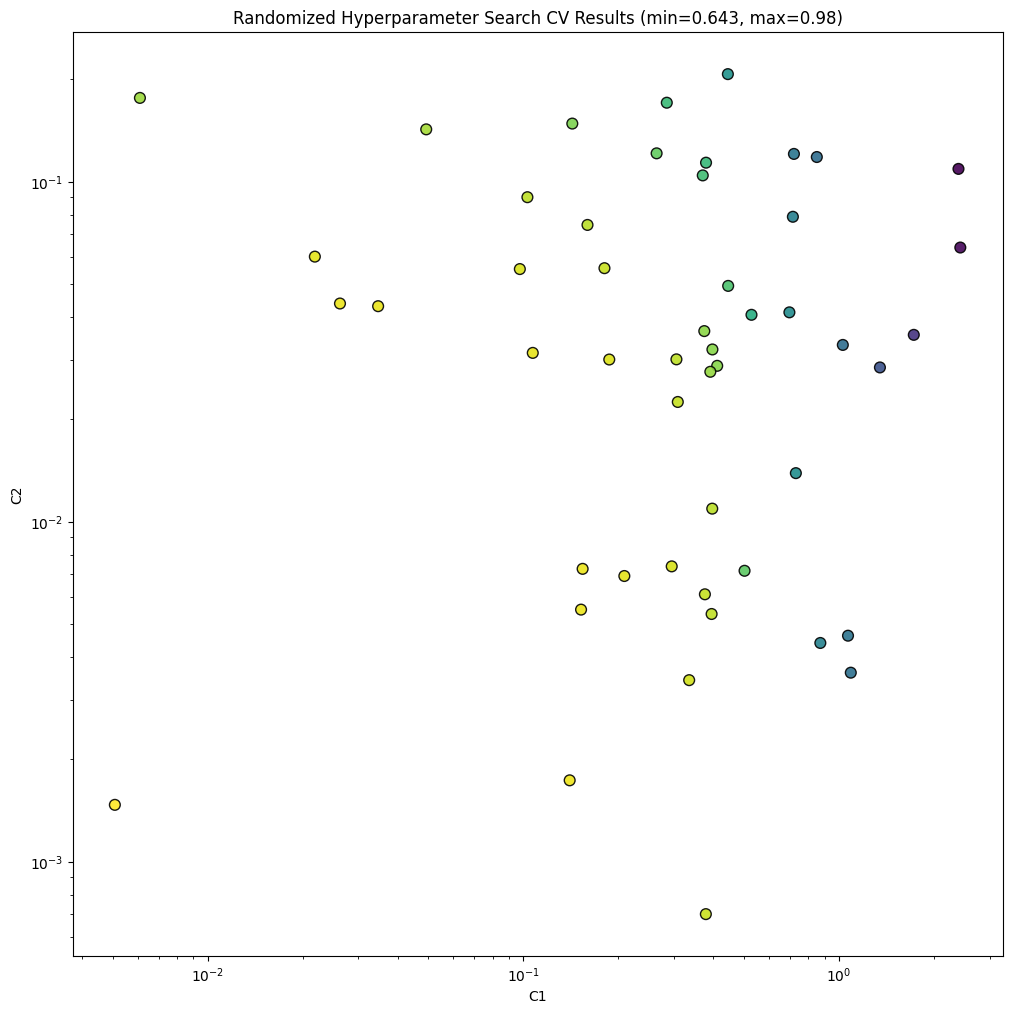

In [ ]:
#_x = [s.parameters['c1'] for s in rs.grid_scores_]
#_y = [s.parameters['c2'] for s in rs.grid_scores_]
#_c = [s.mean_validation_score for s in rs.grid_scores_]

_x = [s['c1'] for s in rs.cv_results_['params']]
_y = [s['c2'] for s in rs.cv_results_['params']]
_c = [s for s in rs.cv_results_['mean_train_score']]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("Dark blue => {:0.4}, dark red => {:0.4}".format(min(_c), max(_c)))

In [ ]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))